# Bagging

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
series = pd.read_table('series.csv', sep=',')
series.head()

,value
0,52.483570
1,49.352750
2,53.314735
3,57.711823
4,48.934444


In [3]:
series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 1 columns):
value    1461 non-null float64
dtypes: float64(1)
memory usage: 11.5 KB


In [4]:
series.describe()

,value
count,1461.000000
mean,53.954441
std,25.399524
min,-21.603771
25%,33.992973
50%,53.336246
75%,73.622010
max,122.307720


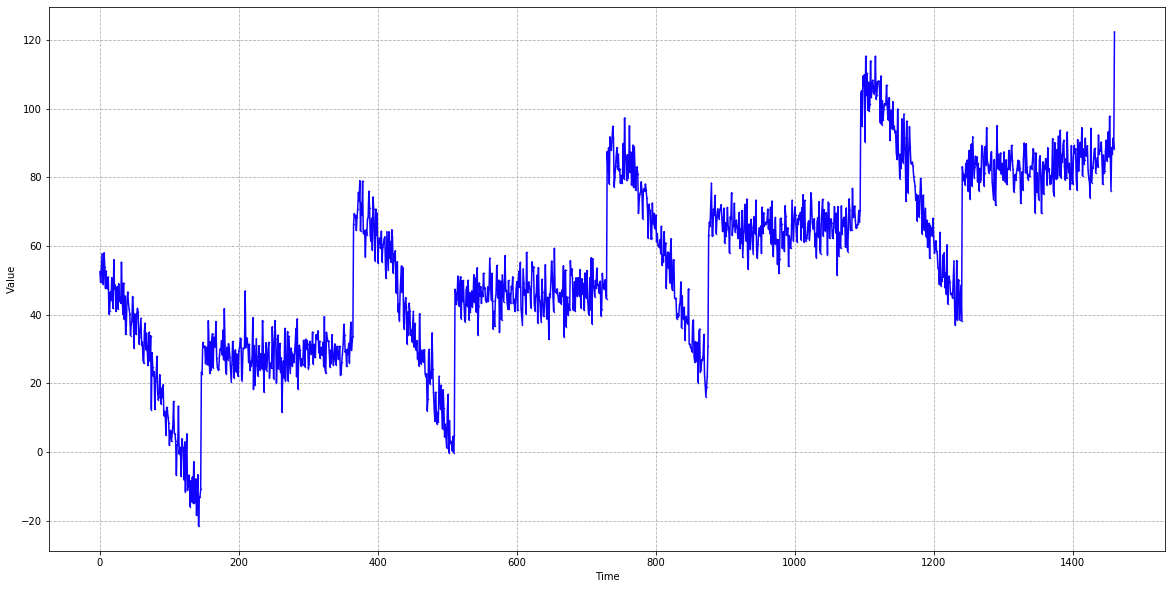

In [5]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.grid(b=True, linestyle='--')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.plot(series.values, marker='.', color='#0F00FF', markersize=1, linestyle='-')

In [6]:
split_time = 1000

t_train = np.array(range(0,split_time+1))
x_train = series.loc[:split_time,['value']].astype('float32').values

t_test = np.array(range(split_time+1,series.shape[0]+1))
x_test = series.loc[split_time:,['value']].astype('float32').values

In [7]:
window_size = 10

X_train = []
Y_train = []
for i in range(x_train.shape[0]-window_size):
    X_train.append(x_train[i:i+window_size,0])
    Y_train.append(x_train[[i+window_size],0])
X_train = np.array(X_train, dtype='float32')
Y_train = np.array(Y_train, dtype='float32')

X_test = []
Y_test = []
for i in range(x_test.shape[0]-window_size):
    X_test.append(x_test[i:i+window_size,0])
    Y_test.append(x_test[[i+window_size],0])
X_test = np.array(X_test, dtype='float32')
Y_test = np.array(Y_test, dtype='float32')

In [8]:
class Layer1():
    
    def __init__(self, model, input_dim, output_dim):
        self.model = model
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def build(self):
        self.weights = []
        self.mu = tf.zeros(shape=(1,self.output_dim), dtype="float32")
        self.sigma = tf.ones(shape=(1,self.output_dim), dtype="float32")

    def __call__(self, inputs):
        return (inputs-self.mu)/self.sigma
    
class Layer2():
    
    def __init__(self, model, input_dim, output_dim):
        self.model = model
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.random.normal(shape=shape, mean=0.0, stddev=0.05, dtype="float32")
        return tf.Variable(initial_value=weight_init, trainable=True)
        
    def build(self):
        self.w = self.add_weight(shape=(self.output_dim, self.input_dim))
        self.b = self.add_weight(shape=(self.output_dim, 1))
        self.weights = [self.w, self.b]

    def __call__(self, inputs):
        z = tf.matmul(self.w, tf.transpose(inputs)) + self.b
        u = tf.transpose(z)
        return tf.math.maximum(0.,u)
    
class Layer3():
    
    def __init__(self, model, input_dim, output_dim):
        self.model = model
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.random.normal(shape=shape, mean=0.0, stddev=0.05, dtype="float32")
        return tf.Variable(initial_value=weight_init, trainable=True)
        
    def build(self):
        self.w = self.add_weight(shape=(self.output_dim, self.input_dim))
        self.b = self.add_weight(shape=(self.output_dim, 1))
        self.weights = [self.w, self.b]

    def __call__(self, inputs):
        z = tf.matmul(self.w, tf.transpose(inputs)) + self.b
        return tf.transpose(z)

In [9]:
class LossFunction():
    
    def __init__(self, model):
        self.model = model

    def __call__(self, y_true, y_pred):
        return tf.math.reduce_mean(tf.math.square(y_true-y_pred))

In [10]:
class MetricFunction():
                    
    def __init__(self, model):
        self.model = model
        
    def __call__(self, y_true, y_pred):
        return tf.math.reduce_mean(tf.math.abs(y_true-y_pred))

In [11]:
class Optimizer():

    def __init__(self, model, learning_rate, beta_1, beta_2, epsilon):
        self.model = model
        self.learning_rate = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon= epsilon
        self.stop_training = False
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.zeros(shape=shape, dtype="float32")
        return  tf.Variable(initial_value=weight_init, trainable=False)
    
    def build(self):
        self.weights = []
        for weight in self.model.weights:
            m = self.add_weight(shape=weight.shape)
            v = self.add_weight(shape=weight.shape)
            self.weights.append([m,v])
            
    def apply(self, grads, weights):
        for i in range(len(weights)):
            w = weights[i]
            grad_w = grads[i]
            m = self.weights[i][0]
            v = self.weights[i][1]
            self.weights[i][0].assign(self.beta_1*m + (1-self.beta_1)*grad_w)  
            self.weights[i][1].assign(self.beta_2*v + (1-self.beta_2)*grad_w*grad_w)
            m_ = (1/(1-self.beta_1))*self.weights[i][0]
            v_ = (1/(1-self.beta_2))*self.weights[i][1]
            weights[i].assign(w - self.learning_rate*m_/(tf.math.sqrt(v_)+self.epsilon))
            
    def train_step(self, X, Y):
        with tf.GradientTape() as tape:
            H = self.model(X)
            loss = self.model.loss(Y, H)
        grads = tape.gradient(loss, self.model.weights)
        self.apply(grads, self.model.weights)
        H = self.model(X)
        loss = self.model.loss(Y, H)
        metric = self.model.metric(Y, H)
        logs = {'loss': loss,
                'metric': metric}
        return logs

In [12]:
class Callback1():

    def __init__(self, model, verbose):
        self.model = model
        self.verbose = verbose
    
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = tf.timestamp()
        
    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            now = tf.timestamp()
            time = now - self.start_time
            tf.print('Epochs {}/{} - Loss: {} - Metric: {}'.format(epoch+1, self.model.epochs, logs['loss'], logs['metric']))
            tf.print('----- {}s -----'.format(tf.round(1000*time)/1000))
            
class Callback2():

    def __init__(self, model):
        self.model = model
        self.history = {'loss':[],
                        'metric':[]}
        
    def on_epoch_end(self, epoch, logs):
        self.history['loss'].append(logs['loss'].numpy())
        self.history['metric'].append(logs['metric'].numpy())
        
    def on_train_end(self):
        self.model.history = self.history

class Callback3():
        
    def __init__(self, model, patience, error, reduce_factor, min_learning_rate):
        self.model = model
        self.patience = patience
        self.error = error
        self.reduce_factor = reduce_factor
        self.min_learning_rate = min_learning_rate
                        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            if (self.model.optimizer.learning_rate>self.min_learning_rate):
                self.model.optimizer.learning_rate = self.reduce_factor*self.model.optimizer.learning_rate
                self.non_decreasing_epochs = 0
        
class Callback4():
        
    def __init__(self, model, patience, error):
        self.model = model
        self.patience = patience
        self.error = error
        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            self.model.optimizer.stop_training = True

In [13]:
class NN():
    
    def __init__(self, dims):
        self.dims = dims
        self.build()
    
    def build(self):
        self.layers = []
        self.layers.append(Layer1(model=self, input_dim=self.dims[0], output_dim=self.dims[0]))
        for i in range(len(self.dims)-2):
            self.layers.append(Layer2(model=self, input_dim=self.dims[i], output_dim=self.dims[i+1]))
        self.layers.append(Layer3(model=self, input_dim=self.dims[-2], output_dim=self.dims[-1]))
        self.weights = []
        for layer in self.layers:
            for weight in layer.weights:
                self.weights.append(weight)
        
    def __call__(self, inputs):
        y = inputs
        for layer in self.layers:
            y = layer(y)
        return y 
        
    def train_setup(self, epochs, learning_rate, beta_1, beta_2, epsilon, verbose):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.beta_1 = beta_1 
        self.beta_2 = beta_2 
        self.epsilon = epsilon
        self.verbose = verbose
        self.loss = LossFunction(model=self)
        self.metric = MetricFunction(model=self)
        self.optimizer = Optimizer(model=self, learning_rate=self.learning_rate, beta_1=self.beta_1, beta_2=self.beta_2, epsilon=self.epsilon)
        self.callbacks = [Callback1(model=self, verbose=self.verbose),
                          Callback2(model=self),
                          Callback3(model=self, patience=100, error=0.001, reduce_factor=0.1, min_learning_rate=0.001),
                          Callback4(model=self, patience=200, error=0.001)]
        
    def fit(self, X, Y, epochs=1000, learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, verbose=True):
        self.layers[0].mu = tf.math.reduce_mean(tf.constant(X, dtype="float32"), axis=0)
        self.layers[0].sigma = tf.math.reduce_std(tf.constant(X, dtype="float32"), axis=0)
        self.train_setup(epochs, learning_rate, beta_1, beta_2, epsilon, verbose)
        if verbose:
            print('Train on {} samples'.format(X.shape[0]))
        for epoch in range(self.epochs):
            self.callbacks[0].on_epoch_begin(epoch)
            logs = self.optimizer.train_step(tf.constant(X, dtype="float32"), tf.constant(Y, dtype="float32"))
            for callback in self.callbacks:
                callback.on_epoch_end(epoch, logs)
            if self.optimizer.stop_training:
                break
        self.callbacks[1].on_train_end()
            
    def predict(self, inputs):
        return self(tf.constant(inputs, dtype="float32")).numpy()
    
    def evaluate(self, X, Y):
        loss = self.loss(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        loss_numpy = loss.numpy()
        metric = self.metric(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        metric_numpy = metric.numpy()
        tf.print('Loss: {} - Metric: {}'.format(loss_numpy, metric_numpy))
        return [loss_numpy, metric_numpy]

In [14]:
nn = NN(dims=[X_train.shape[1], 32, Y_train.shape[1]])

nn.fit(X_train, Y_train)

Train on 991 samples
Epochs 1/1000 - Loss: 2250.846923828125 - Metric: 43.10955047607422
----- 0.042s -----
Epochs 2/1000 - Loss: 2240.028076171875 - Metric: 43.01746368408203
----- 0.007s -----
Epochs 3/1000 - Loss: 2225.474853515625 - Metric: 42.8896484375
----- 0.006s -----
Epochs 4/1000 - Loss: 2205.26806640625 - Metric: 42.70977783203125
----- 0.009s -----
Epochs 5/1000 - Loss: 2178.64892578125 - Metric: 42.4703369140625
----- 0.01s -----
Epochs 6/1000 - Loss: 2144.857421875 - Metric: 42.163658142089844
----- 0.008s -----
Epochs 7/1000 - Loss: 2103.276123046875 - Metric: 41.784339904785156
----- 0.008s -----
Epochs 8/1000 - Loss: 2053.58740234375 - Metric: 41.32721710205078
----- 0.012s -----
Epochs 9/1000 - Loss: 1995.63134765625 - Metric: 40.78901290893555
----- 0.01s -----
Epochs 10/1000 - Loss: 1929.439453125 - Metric: 40.16600799560547
----- 0.009s -----
Epochs 11/1000 - Loss: 1855.30322265625 - Metric: 39.45511245727539
----- 0.011s -----
Epochs 12/1000 - Loss: 1773.78454589

----- 0.008s -----
Epochs 94/1000 - Loss: 127.97571563720703 - Metric: 8.830574989318848
----- 0.007s -----
Epochs 95/1000 - Loss: 125.09613800048828 - Metric: 8.723109245300293
----- 0.009s -----
Epochs 96/1000 - Loss: 122.30957794189453 - Metric: 8.625503540039062
----- 0.008s -----
Epochs 97/1000 - Loss: 119.62487030029297 - Metric: 8.534977912902832
----- 0.009s -----
Epochs 98/1000 - Loss: 117.02975463867188 - Metric: 8.44807243347168
----- 0.011s -----
Epochs 99/1000 - Loss: 114.52096557617188 - Metric: 8.362360954284668
----- 0.009s -----
Epochs 100/1000 - Loss: 112.09870147705078 - Metric: 8.274770736694336
----- 0.012s -----
Epochs 101/1000 - Loss: 109.76823425292969 - Metric: 8.184258460998535
----- 0.011s -----
Epochs 102/1000 - Loss: 107.52897644042969 - Metric: 8.091343879699707
----- 0.01s -----
Epochs 103/1000 - Loss: 105.37680053710938 - Metric: 7.999355316162109
----- 0.009s -----
Epochs 104/1000 - Loss: 103.3148193359375 - Metric: 7.910438060760498
----- 0.01s -----
E

----- 0.009s -----
Epochs 186/1000 - Loss: 47.87657928466797 - Metric: 5.200200080871582
----- 0.01s -----
Epochs 187/1000 - Loss: 47.774696350097656 - Metric: 5.194601058959961
----- 0.007s -----
Epochs 188/1000 - Loss: 47.67925262451172 - Metric: 5.189431667327881
----- 0.007s -----
Epochs 189/1000 - Loss: 47.58998489379883 - Metric: 5.184680461883545
----- 0.007s -----
Epochs 190/1000 - Loss: 47.50423049926758 - Metric: 5.180131912231445
----- 0.008s -----
Epochs 191/1000 - Loss: 47.417518615722656 - Metric: 5.1755475997924805
----- 0.008s -----
Epochs 192/1000 - Loss: 47.33290100097656 - Metric: 5.170989513397217
----- 0.007s -----
Epochs 193/1000 - Loss: 47.250640869140625 - Metric: 5.166383266448975
----- 0.007s -----
Epochs 194/1000 - Loss: 47.172821044921875 - Metric: 5.1619062423706055
----- 0.008s -----
Epochs 195/1000 - Loss: 47.09844970703125 - Metric: 5.157796859741211
----- 0.008s -----
Epochs 196/1000 - Loss: 47.026065826416016 - Metric: 5.153841495513916
----- 0.008s --

----- 0.008s -----
Epochs 278/1000 - Loss: 44.7109489440918 - Metric: 5.026886463165283
----- 0.009s -----
Epochs 279/1000 - Loss: 44.70172882080078 - Metric: 5.026435375213623
----- 0.009s -----
Epochs 280/1000 - Loss: 44.69245910644531 - Metric: 5.026019096374512
----- 0.008s -----
Epochs 281/1000 - Loss: 44.68344497680664 - Metric: 5.025588035583496
----- 0.008s -----
Epochs 282/1000 - Loss: 44.674373626708984 - Metric: 5.025017738342285
----- 0.007s -----
Epochs 283/1000 - Loss: 44.66547775268555 - Metric: 5.02435827255249
----- 0.008s -----
Epochs 284/1000 - Loss: 44.65703201293945 - Metric: 5.023734092712402
----- 0.008s -----
Epochs 285/1000 - Loss: 44.648773193359375 - Metric: 5.023226261138916
----- 0.007s -----
Epochs 286/1000 - Loss: 44.640621185302734 - Metric: 5.0227508544921875
----- 0.007s -----
Epochs 287/1000 - Loss: 44.63259506225586 - Metric: 5.022265434265137
----- 0.009s -----
Epochs 288/1000 - Loss: 44.624717712402344 - Metric: 5.021792411804199
----- 0.009s -----

----- 0.011s -----
Epochs 370/1000 - Loss: 44.23158645629883 - Metric: 4.992264747619629
----- 0.01s -----
Epochs 371/1000 - Loss: 44.22895050048828 - Metric: 4.991980075836182
----- 0.009s -----
Epochs 372/1000 - Loss: 44.22636413574219 - Metric: 4.991636276245117
----- 0.009s -----
Epochs 373/1000 - Loss: 44.22383499145508 - Metric: 4.991332530975342
----- 0.008s -----
Epochs 374/1000 - Loss: 44.22134017944336 - Metric: 4.991101264953613
----- 0.008s -----
Epochs 375/1000 - Loss: 44.2188606262207 - Metric: 4.990917682647705
----- 0.007s -----
Epochs 376/1000 - Loss: 44.2164306640625 - Metric: 4.990795612335205
----- 0.009s -----
Epochs 377/1000 - Loss: 44.21406936645508 - Metric: 4.990655422210693
----- 0.008s -----
Epochs 378/1000 - Loss: 44.21175765991211 - Metric: 4.990444660186768
----- 0.009s -----
Epochs 379/1000 - Loss: 44.209442138671875 - Metric: 4.990175724029541
----- 0.008s -----
Epochs 380/1000 - Loss: 44.207176208496094 - Metric: 4.989902019500732
----- 0.007s -----
Epo

----- 0.009s -----
Epochs 462/1000 - Loss: 44.08493423461914 - Metric: 4.979578018188477
----- 0.01s -----
Epochs 463/1000 - Loss: 44.08412170410156 - Metric: 4.979526996612549
----- 0.011s -----
Epochs 464/1000 - Loss: 44.083309173583984 - Metric: 4.979458332061768
----- 0.011s -----
Epochs 465/1000 - Loss: 44.08247375488281 - Metric: 4.9794158935546875
----- 0.009s -----
Epochs 466/1000 - Loss: 44.08167266845703 - Metric: 4.9793381690979
----- 0.008s -----
Epochs 467/1000 - Loss: 44.080806732177734 - Metric: 4.979259490966797
----- 0.008s -----
Epochs 468/1000 - Loss: 44.07994079589844 - Metric: 4.979145050048828
----- 0.007s -----
Epochs 469/1000 - Loss: 44.079124450683594 - Metric: 4.979056358337402
----- 0.007s -----
Epochs 470/1000 - Loss: 44.078330993652344 - Metric: 4.9789533615112305
----- 0.008s -----
Epochs 471/1000 - Loss: 44.07749557495117 - Metric: 4.97887659072876
----- 0.008s -----
Epochs 472/1000 - Loss: 44.076690673828125 - Metric: 4.978785037994385
----- 0.008s -----

----- 0.008s -----
Epochs 554/1000 - Loss: 44.03282928466797 - Metric: 4.9751081466674805
----- 0.007s -----
Epochs 555/1000 - Loss: 44.03242874145508 - Metric: 4.9750237464904785
----- 0.009s -----
Epochs 556/1000 - Loss: 44.03206253051758 - Metric: 4.974998474121094
----- 0.009s -----
Epochs 557/1000 - Loss: 44.03173065185547 - Metric: 4.975063323974609
----- 0.011s -----
Epochs 558/1000 - Loss: 44.031375885009766 - Metric: 4.974996089935303
----- 0.01s -----
Epochs 559/1000 - Loss: 44.031028747558594 - Metric: 4.974856853485107
----- 0.01s -----
Epochs 560/1000 - Loss: 44.03068161010742 - Metric: 4.974795341491699
----- 0.01s -----
Epochs 561/1000 - Loss: 44.03028106689453 - Metric: 4.974825382232666
----- 0.01s -----
Epochs 562/1000 - Loss: 44.029991149902344 - Metric: 4.974929332733154
----- 0.011s -----
Epochs 563/1000 - Loss: 44.029624938964844 - Metric: 4.974897384643555
----- 0.011s -----
Epochs 564/1000 - Loss: 44.02920913696289 - Metric: 4.974736213684082
----- 0.01s -----
E

----- 0.008s -----
Epochs 646/1000 - Loss: 44.00017547607422 - Metric: 4.972555637359619
----- 0.008s -----
Epochs 647/1000 - Loss: 43.99980926513672 - Metric: 4.972554683685303
----- 0.008s -----
Epochs 648/1000 - Loss: 43.999542236328125 - Metric: 4.972571849822998
----- 0.009s -----
Epochs 649/1000 - Loss: 43.99917984008789 - Metric: 4.972602844238281
----- 0.007s -----
Epochs 650/1000 - Loss: 43.99888610839844 - Metric: 4.972588062286377
----- 0.009s -----
Epochs 651/1000 - Loss: 43.99852752685547 - Metric: 4.972553253173828
----- 0.01s -----
Epochs 652/1000 - Loss: 43.99824523925781 - Metric: 4.972465515136719
----- 0.009s -----
Epochs 653/1000 - Loss: 43.9979362487793 - Metric: 4.972442150115967
----- 0.009s -----
Epochs 654/1000 - Loss: 43.99757766723633 - Metric: 4.97244119644165
----- 0.011s -----
Epochs 655/1000 - Loss: 43.99721145629883 - Metric: 4.972433567047119
----- 0.009s -----
Epochs 656/1000 - Loss: 43.99684524536133 - Metric: 4.972386837005615
----- 0.009s -----
Epoc

Epochs 738/1000 - Loss: 43.96918869018555 - Metric: 4.970252990722656
----- 0.008s -----
Epochs 739/1000 - Loss: 43.96885299682617 - Metric: 4.970248699188232
----- 0.009s -----
Epochs 740/1000 - Loss: 43.968505859375 - Metric: 4.970332145690918
----- 0.008s -----
Epochs 741/1000 - Loss: 43.968143463134766 - Metric: 4.97023868560791
----- 0.008s -----
Epochs 742/1000 - Loss: 43.967864990234375 - Metric: 4.970071315765381
----- 0.007s -----
Epochs 743/1000 - Loss: 43.967491149902344 - Metric: 4.970074653625488
----- 0.008s -----
Epochs 744/1000 - Loss: 43.967159271240234 - Metric: 4.970203399658203
----- 0.008s -----
Epochs 745/1000 - Loss: 43.96688461303711 - Metric: 4.970271110534668
----- 0.007s -----
Epochs 746/1000 - Loss: 43.96649932861328 - Metric: 4.970194339752197
----- 0.011s -----
Epochs 747/1000 - Loss: 43.96607208251953 - Metric: 4.969999313354492
----- 0.01s -----
Epochs 748/1000 - Loss: 43.965797424316406 - Metric: 4.969906806945801
----- 0.01s -----
Epochs 749/1000 - Los

----- 0.009s -----
Epochs 831/1000 - Loss: 43.9373664855957 - Metric: 4.967906475067139
----- 0.009s -----
Epochs 832/1000 - Loss: 43.937015533447266 - Metric: 4.967910289764404
----- 0.009s -----
Epochs 833/1000 - Loss: 43.93656921386719 - Metric: 4.96784782409668
----- 0.009s -----
Epochs 834/1000 - Loss: 43.93624496459961 - Metric: 4.967764377593994
----- 0.008s -----
Epochs 835/1000 - Loss: 43.93587875366211 - Metric: 4.9677734375
----- 0.008s -----
Epochs 836/1000 - Loss: 43.935550689697266 - Metric: 4.967872619628906
----- 0.007s -----
Epochs 837/1000 - Loss: 43.93524169921875 - Metric: 4.967848777770996
----- 0.007s -----
Epochs 838/1000 - Loss: 43.934844970703125 - Metric: 4.967798709869385
----- 0.008s -----
Epochs 839/1000 - Loss: 43.93452453613281 - Metric: 4.96766996383667
----- 0.009s -----
Epochs 840/1000 - Loss: 43.934146881103516 - Metric: 4.96759557723999
----- 0.009s -----
Epochs 841/1000 - Loss: 43.93373489379883 - Metric: 4.967587471008301
----- 0.009s -----
Epochs 

Epochs 923/1000 - Loss: 43.90373611450195 - Metric: 4.965198040008545
----- 0.007s -----
Epochs 924/1000 - Loss: 43.90326690673828 - Metric: 4.965166091918945
----- 0.006s -----
Epochs 925/1000 - Loss: 43.90285110473633 - Metric: 4.96523380279541
----- 0.008s -----
Epochs 926/1000 - Loss: 43.902496337890625 - Metric: 4.965264320373535
----- 0.009s -----
Epochs 927/1000 - Loss: 43.90202713012695 - Metric: 4.965247631072998
----- 0.007s -----
Epochs 928/1000 - Loss: 43.901641845703125 - Metric: 4.96515417098999
----- 0.007s -----
Epochs 929/1000 - Loss: 43.90118408203125 - Metric: 4.965070724487305
----- 0.007s -----
Epochs 930/1000 - Loss: 43.9007568359375 - Metric: 4.965032577514648
----- 0.009s -----
Epochs 931/1000 - Loss: 43.90037536621094 - Metric: 4.964968681335449
----- 0.009s -----
Epochs 932/1000 - Loss: 43.90000915527344 - Metric: 4.964971542358398
----- 0.007s -----
Epochs 933/1000 - Loss: 43.89963912963867 - Metric: 4.96513032913208
----- 0.008s -----
Epochs 934/1000 - Loss:

In [15]:
nn.evaluate(X_test, Y_test)

Loss: 44.983726501464844 - Metric: 4.9452738761901855


[44.983727, 4.945274]

In [16]:
class Bagging():
    
    def __init__(self, bag_size, model):
        self.bag_size = bag_size
        self.model = model
        self.build()
    
    def build(self):
        self.bag = [] 
        for i in range(self.bag_size):
            m = self.model.__class__(dims=self.model.dims)
            self.bag.append(m)
                    
    def __call__(self, inputs):
        outputs = []
        for i in range(self.bag_size):
            outputs.append(self.bag[i](inputs))
        z = tf.concat(outputs, axis=1)
        y = tf.math.reduce_mean(z, axis=1, keepdims=True)
        return y
    
    def train_setup(self, epochs, learning_rate, beta_1, beta_2, epsilon, verbose):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.beta_1 = beta_1 
        self.beta_2 = beta_2 
        self.epsilon = epsilon
        self.verbose = verbose
        self.loss = self.model.loss.__class__(model=self)
        self.metric = self.model.metric.__class__(model=self)
        
    def fit(self, X, Y, epochs=1000, learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, verbose=False):
        self.train_setup(epochs, learning_rate, beta_1, beta_2, epsilon, verbose)   
        k = X.shape[0]//self.bag_size
        tf.print('Bagging with {} models'.format(self.bag_size))
        for i in range(self.bag_size):
            start_time = tf.timestamp()
            tf.print('Training model {}/{}'.format(i+1, self.bag_size))
            X_ = np.concatenate((X[:i*k,:], X[(i+1)*k:,:]))
            Y_ = np.concatenate((Y[:i*k,:], Y[(i+1)*k:,:]))  
            self.bag[i].fit(X_, Y_, epochs=self.epochs, learning_rate=self.learning_rate, beta_1=self.beta_1, beta_2=self.beta_2, epsilon=self.epsilon, verbose=self.verbose)
            now = tf.timestamp()
            time = now - start_time
            tf.print('----- {}s -----'.format(tf.round(1000*time)/1000))
        loss = self.loss(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        loss_numpy = loss.numpy()
        metric = self.metric(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        metric_numpy = metric.numpy()
        tf.print('Loss: {} - Metric: {}'.format(loss_numpy, metric_numpy))
          
    def predict(self, inputs):
        return self(tf.constant(inputs, dtype="float32")).numpy()
    
    def evaluate(self, X, Y):
        loss = self.loss(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        loss_numpy = loss.numpy()
        metric = self.metric(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        metric_numpy = metric.numpy()
        tf.print('Loss: {} - Metric: {}'.format(loss_numpy, metric_numpy))
        return [loss_numpy, metric_numpy]

In [17]:
bagging = Bagging(bag_size=3, model=nn)

bagging.fit(X_train, Y_train)

Bagging with 3 models
Training model 1/3
----- 5.98s -----
Training model 2/3
----- 5.971s -----
Training model 3/3
----- 5.959s -----
Loss: 40.651153564453125 - Metric: 4.748203754425049


In [18]:
bagging.evaluate(X_test, Y_test)

Loss: 45.90233612060547 - Metric: 4.950803279876709


[45.902336, 4.9508033]